<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v11: Combining weights, gradients, and unit activity
I've now created separate utilities for collecting gradients, variables, and unit activation during training.

Now let's prove that they work together well and can be combined.
This will be a precursor to creating a utility for "explaining" near-zero gradients.

In [66]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout 1d0d3ea
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

HEAD is now at 9282a44 Bug fixes and tidy ups in ActivityHistoryCallback
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (delta 4), reused 6 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 789 bytes | 98.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   9282a44..9432c1a  main       -> origin/main
Updating 9282a44..9432c1a
Fast-forward
 train_observability_toolkit.py | 33 ++++++++++++++++++---------------
 1 file changed, 18 insertions(+), 15 deletions(-)


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [67]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [39]:
import keras
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


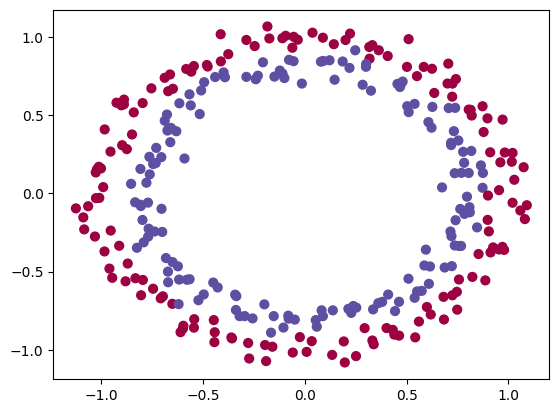

In [4]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [5]:
model = binary_classification_model('he_normal')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,611 (162.54 KB)

 Trainable params: 41,411 (161.76 KB)

 Non-trainable params: 200 (800.00 B)

## Full data collection
First we'll train the model and collect all stats, plus collect detailed raw values for some selected layers.

Recall that we have the following basic API and that all of these data collection callbacks now need to consistently support this (with some variables between variable-based vs output-based callbacks):
```python
collection_sets = [
    {
      # one of:
      'layers': [Layer] # references to actual layers, OR
      'layer_indices': [int]  # list of layer indices, OR
      'layer_names': [string]  # list of layer names, OR
      'variable_indices': [int]  # list of variable indices according to model.variables, OR
      'trainable_variable_indices': [int]  # list of variable indices according to model.trainable_variables

      # one of (not actually implemented yet):
      'density': float, default: 1.0  # fraction of units to collect outputs from, automatically sliced, OR
      'max_units': int, default: None  # max number of units to collect outputs from, automatically sliced, OR
      'slices': [slice]  # slices to use for each selected variable
    }
]
```

In [68]:
reload(tot)
tf.config.run_functions_eagerly(False)

collection_sets = [{}]
variables = tot.VariableHistoryCallback(per_step=True, before_updates=True, collection_sets=collection_sets)
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=collection_sets)
activity = tot.ActivityHistoryCallback(per_step=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=5, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, activity])

Epoch     1 - 10.24s/epoch: loss: 0.7246  
Epoch     2 - 753.26ms/epoch: loss: 0.6858  
Epoch     3 - 732.96ms/epoch: loss: 0.6597  
Epoch     4 - 758.39ms/epoch: loss: 0.6570  
Epoch     5 - 728.63ms/epoch: loss: 0.6471  


In [69]:
# Validate that the callbacks all got the right things on the output
print("Variables callback:")
print(f"Iterations: {variables.epochs if hasattr(variables, 'epochs') else variables.steps}")
print(f"Model stats: {variables.model_stats.keys()} x {len(variables.model_stats['mean'])}")
print(f"Layer stats: {[len(layer_stat) if layer_stat else None for layer_stat in variables.layer_stats]}: {variables.layer_stats[0].keys()} x {len(variables.layer_stats[0]['mean'])}")
print(f"Variable stats: {[len(variable_stat) if variable_stat else None for variable_stat in variables.variable_stats]}: {variables.variable_stats[0].keys()} x {len(variables.variable_stats[0]['mean'])}")
print(f"callback.collected_variables:")
for var_idx, var_list in zip(variables.collected_variable_indices, variables.collected_variables):
  print(f"  variable {var_idx}: len={len(var_list)} x type={type(var_list[0])} x {var_list[0].shape}")

print()
print("Gradients callback:")
print(f"Iterations: {gradients.epochs if hasattr(gradients, 'epochs') else gradients.steps}")
print(f"Model stats: {gradients.model_stats.keys()} x {len(gradients.model_stats['mean'])}")
print(f"Layer stats: {[len(layer_stat) if layer_stat else None for layer_stat in gradients.layer_stats]}: {gradients.layer_stats[0].keys()} x {len(gradients.layer_stats[0]['mean'])}")
print(f"Variable stats: {[len(gradient_stat) if gradient_stat else None for gradient_stat in gradients.gradient_stats]}: {gradients.gradient_stats[0].keys()} x {len(gradients.gradient_stats[0]['mean'])}")
print(f"callback.collected_gradients:")
for var_idx, var_list in zip(gradients.collected_gradient_indices, gradients.collected_gradients):
  print(f"  gradient {var_idx}: len={len(var_list)} x type={type(var_list[0])} x {var_list[0].shape}")


print()
print("Activity callback:")
print(f"Iterations: {activity.epochs if hasattr(activity, 'epochs') else activity.steps}")
print(f"Model stats: {activity.model_stats.keys()} x {len(activity.model_stats['mean_dead_rate'])}")
print(f"Layer stats: {[len(layer_stat) if layer_stat else None for layer_stat in activity.layer_stats]}: {activity.layer_stats[0].keys()} x {len(activity.layer_stats[0]['dead_rate'])}")
print(f"callback.collected_layer_outputs:")
for l_idx, output_list in zip(activity.collected_layer_output_indices, activity.collected_layer_outputs):
    print(f"  layer {l_idx}: len={len(output_list)} x type={type(output_list[0])} x {output_list[0].shape}")


Variables callback:
Iterations: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Model stats: dict_keys(['mean', 'min', 'max', 'std']) x 50
Layer stats: [4, 4, None, 4, 4, None, 4, 4, 4, 4]: dict_keys(['mean', 'min', 'max', 'std']) x 50
Variable stats: [4, 4, 4, 4, None, 4, 4, 4, 4, None, 4, 4, 4, 4, None, None, 4, 4, 4, 4]: dict_keys(['mean', 'min', 'max', 'std']) x 50
callback.collected_variables:
  variable 0: len=50 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (2, 100)
  variable 1: len=50 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (100,)
  variable 2: len=50 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (100, 100)
  variable 3: len=50 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (100,)
  variable 5: len=50 x type=<class 'tensorflow.python.framework.ops.EagerTensor'> x (100, 100)
  variable 6: len=50 x type

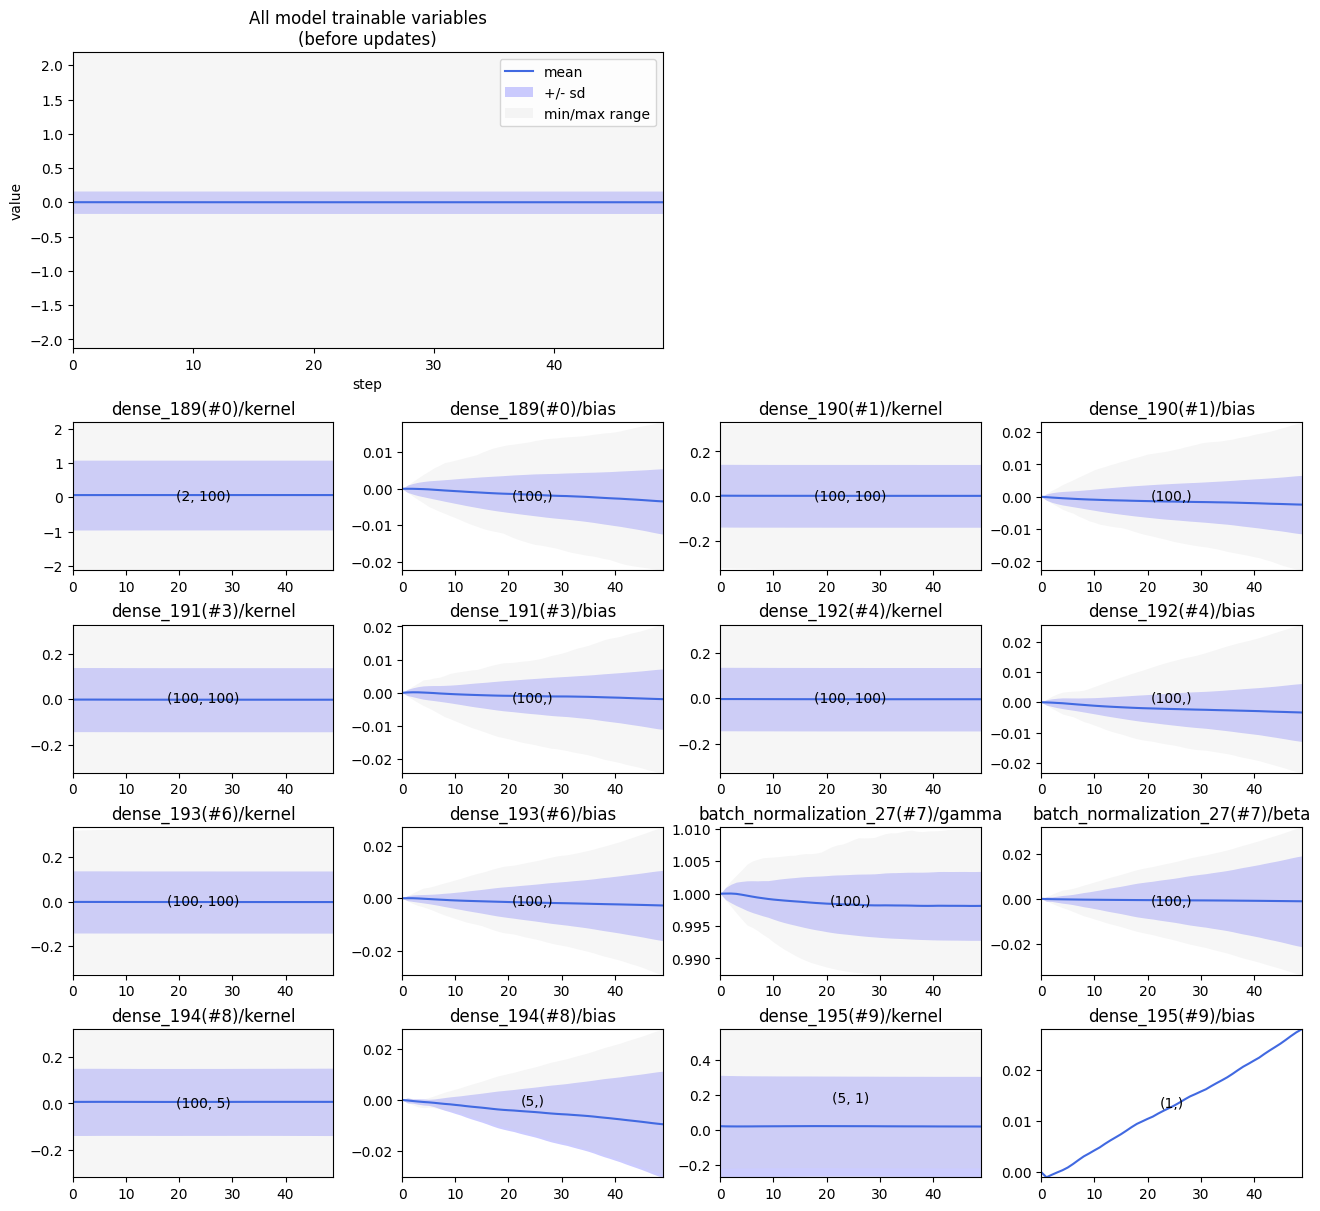

In [71]:
tot.plot_variable_history(variables)

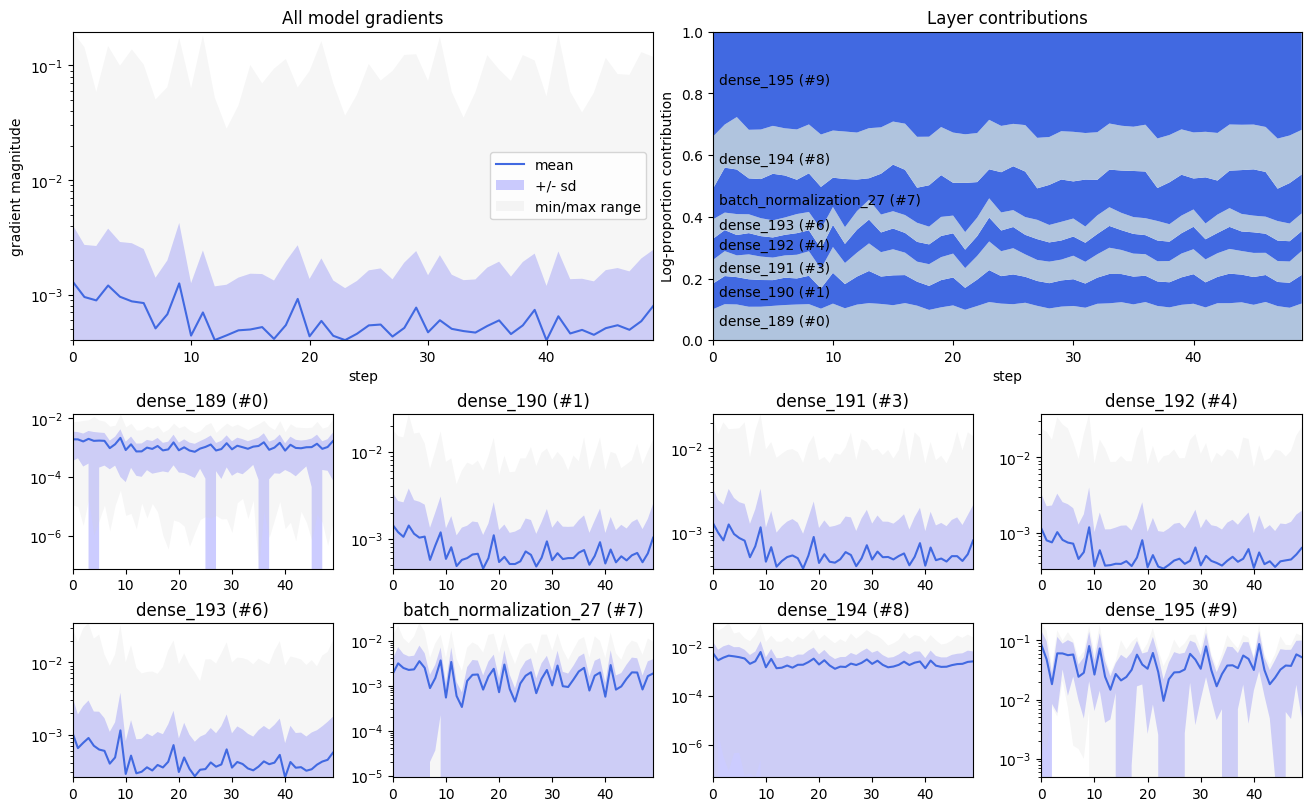

In [72]:
tot.plot_gradient_history(gradients)

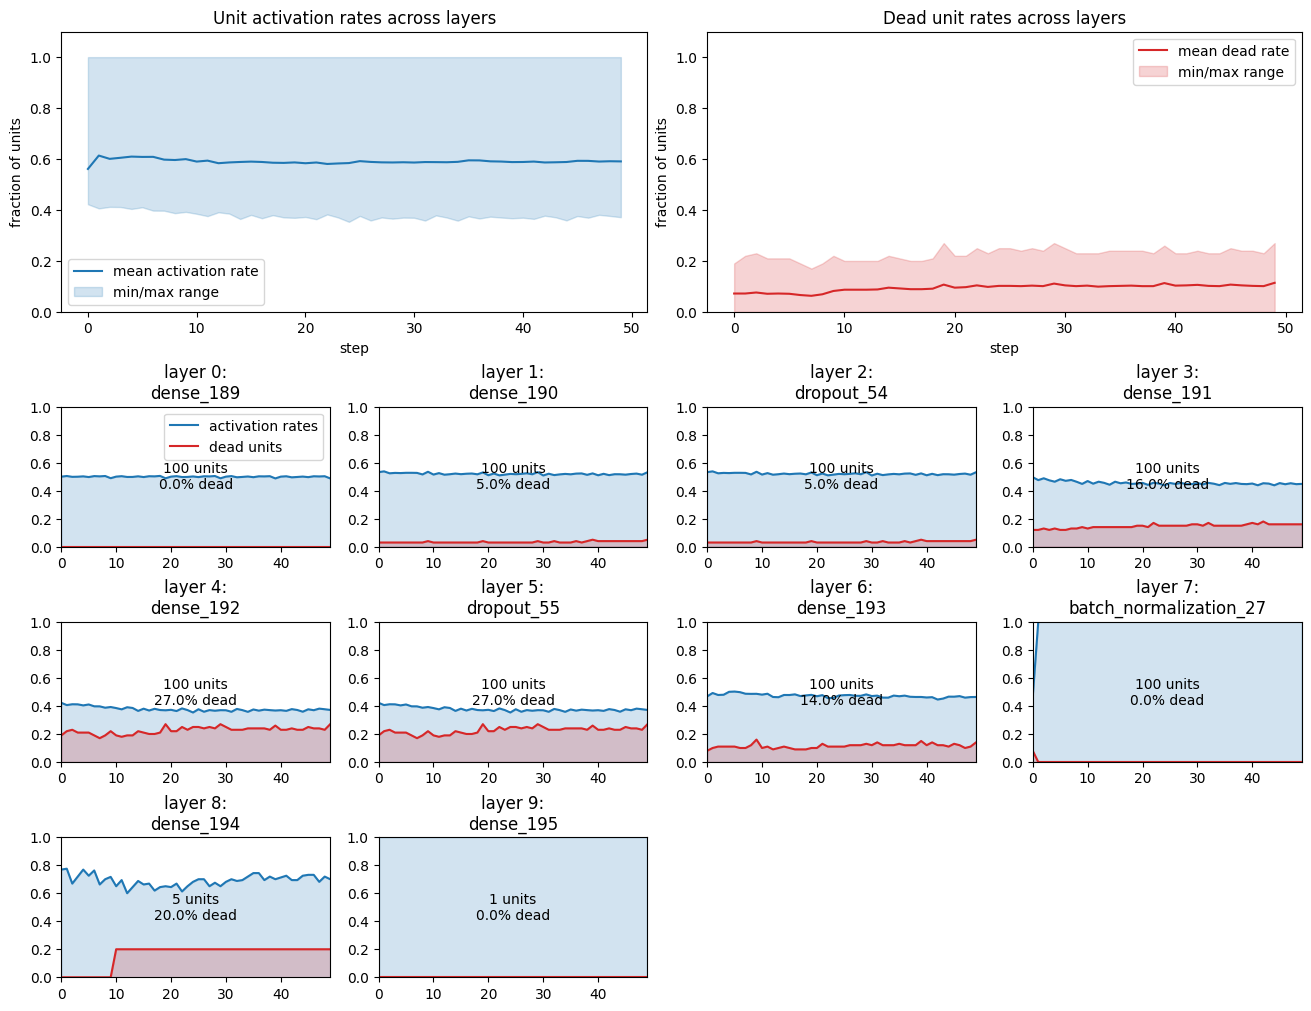

In [73]:
tot.plot_unit_activity(activity)

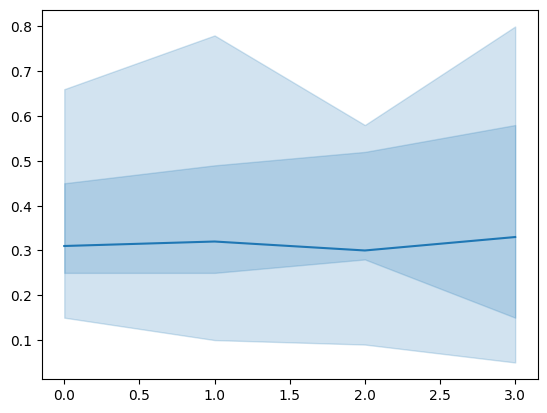

In [10]:
x = np.arange(4)
p99 = np.array([0.66, 0.78, 0.58, 0.80])
p75 = np.array([0.45, 0.49, 0.52, 0.58])
p50 = np.array([0.31, 0.32, 0.30, 0.33])
p25 = np.array([0.25, 0.25, 0.28, 0.15])
p00 = np.array([0.15, 0.10, 0.09, 0.05])

plt.plot(x, p50)
plt.fill_between(x, p25, p75, alpha=0.2, color='tab:blue')
plt.fill_between(x, p00, p99, alpha=0.2, color='tab:blue')